<img title="GitHub Octocat" src='./img/Octocat.jpg' style='height: 60px; padding-right: 15px' alt="Octocat" align="left" height="60"> This notebook is part of a GitHub repository: https://github.com/pessini/moby-bikes
<br>MIT Licensed
<br>Author: Leandro Pessini

# Feature Engineering

In [82]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np
from datetime import datetime
import scipy.stats as stats
from patsy import dmatrices

# statsmodels
from statsmodels.stats import diagnostic as diag
import statsmodels.api as sm
from statsmodels.formula.api import glm
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor

%matplotlib inline
import warnings
warnings.simplefilter('ignore', FutureWarning)

In [2]:
%reload_ext watermark
%watermark -a "Leandro Pessini" -n -u -v -iv -w

Author: Leandro Pessini

Last updated: Thu May 12 2022

Python implementation: CPython
Python version       : 3.9.6
IPython version      : 8.3.0

numpy      : 1.21.1
statsmodels: 0.13.2
seaborn    : 0.11.1
matplotlib : 3.4.2
sys        : 3.9.6 | packaged by conda-forge | (default, Jul 11 2021, 03:36:15) 
[Clang 11.1.0 ]
pandas     : 1.3.0
scipy      : 1.8.0

Watermark: 2.3.0



In [118]:
df_train = pd.read_csv('../data/interim/dfsample_train.csv', parse_dates=['date'])
df_test = pd.read_csv('../data/interim/dfsample_test.csv', parse_dates=['date'])
all_data = pd.read_csv('../data/interim/all_data.csv', 
                       parse_dates=['lastrentalstart','lastgpstime','date'])
df_train.head()

,rain,temp,rhum,wdsp,date,hour,day,month,year,count
0,0.0,0.1,98,4,2021-03-01,0,1,3,2021,0
1,0.0,-1.1,98,3,2021-03-01,1,1,3,2021,0
2,0.0,-1.2,98,4,2021-03-01,2,1,3,2021,1
3,0.0,-0.9,100,5,2021-03-01,3,1,3,2021,0
4,0.0,0.0,100,6,2021-03-01,4,1,3,2021,0


## Hypothesis

Hourly trend: It might be a high demand for people commuting to work. Early morning and late evening can have different trend (cyclist) and low demand during 10:00 pm to 4:00 am.

Daily Trend: Users demand more bike on weekdays as compared to weekend or holiday.

Rain: The demand of bikes will be lower on a rainy day as compared to a sunny day. Similarly, higher humidity will cause to lower the demand and vice versa.

Temperature: In Ireland, temperature has positive correlation with bike demand.

Traffic: It can be positively correlated with Bike demand. Higher traffic may force people to use bike as compared to other road transport medium like car, taxi etc.



### Date and time - new features
- `holiday`
- `workingday`
- `peak`
- `season`: (1 = Spring, 2 = Summer, 3 = Fall, 4 = Winter)
- `duration`*: duration of the rental

## Bank Holidays

In [119]:
from functools import lru_cache

@lru_cache(maxsize=None)
def get_irish_bank_holidays() -> np.ndarray:
    '''
    Returns a Panda Series of Irish Bank Holidays
    '''
    bank_holidays = pd.read_json('../data/external/irishcalendar.json')
    bank_holidays['date'] = pd.to_datetime(arg=bank_holidays['date'], utc=True, infer_datetime_format=True)
    bank_holidays['dt'] = pd.to_datetime(bank_holidays['date'].dt.date)
    bank_holidays = bank_holidays[bank_holidays['type'] == 'National holiday']
    
    return bank_holidays['dt'].values # np.ndarray

def isBankHoliday(date: pd.DatetimeIndex) -> bool:
    '''
    Receives a date and returns if it is an Irish Bank Holiday
    '''
    bank_holidays = get_irish_bank_holidays()
    return (pd.Timestamp(date) in bank_holidays)

In [120]:
# holiday
# isBankHoliday(datetime.datetime(2020,3,17))
df_train['holiday'] = df_train['date'].map(isBankHoliday)
df_test['holiday'] = df_test['date'].map(isBankHoliday)
all_data['holiday'] = all_data['date'].map(isBankHoliday)

In [121]:
def get_day_of_week_number(date: pd.DatetimeIndex) -> int:
    return date.dayofweek

def get_day_of_week_str(date: pd.DatetimeIndex) -> str:
    return date.day_name()

def isWorkingDay(date: pd.DatetimeIndex) -> bool:
    return (get_day_of_week_number(date) < 5)

# day of the week
df_train['dayofweek_n'] = df_train['date'].map(get_day_of_week_number)
df_train['dayofweek'] = df_train['date'].map(get_day_of_week_str)

df_test['dayofweek_n'] = df_test['date'].map(get_day_of_week_number)
df_test['dayofweek'] = df_test['date'].map(get_day_of_week_str)

all_data['dayofweek'] = all_data['date'].map(get_day_of_week_str)

# working day (Monday=0, Sunday=6)
# from 0 to 4 or monday to friday and is not holiday
df_train['working_day'] = df_train['date'].map(isWorkingDay)
df_test['working_day'] = df_test['date'].map(isWorkingDay)
all_data['working_day'] = all_data['date'].map(isWorkingDay)

# set working_day to False on National Bank Holidays
df_train.loc[ df_train['holiday'] , 'working_day'] = False
df_test.loc[ df_test['holiday'] , 'working_day'] = False
all_data.loc[ all_data['holiday'] , 'working_day'] = False

## Seasons

In [124]:
def get_season(date: pd.DatetimeIndex) -> str:
    '''
        Receives a date and returns the corresponded season
        0 - Spring | 1 - Summer | 2 - Autumn | 3 - Winter
        Vernal equinox(about March 21): day and night of equal length, marking the start of spring
        Summer solstice (June 20 or 21): longest day of the year, marking the start of summer
        Autumnal equinox(about September 23): day and night of equal length, marking the start of autumn
        Winter solstice (December 21 or 22): shortest day of the year, marking the start of winter
    '''
    Y = 2000 # dummy leap year to allow input X-02-29 (leap day)
    seasons = [('Winter', (datetime(Y,  1,  1),  datetime(Y,  3, 20))),
            ('Spring', (datetime(Y,  3, 21),  datetime(Y,  6, 20))),
            ('Summer', (datetime(Y,  6, 21),  datetime(Y,  9, 22))),
            ('Autumn', (datetime(Y,  9, 23),  datetime(Y, 12, 20))),
            ('Winter', (datetime(Y, 12, 21),  datetime(Y, 12, 31)))]
    date = date.replace(year=Y)
    return next(season for season, (start, end) in seasons if start <= date <= end)

df_train['season'] = df_train['date'].map(get_season)
df_test['season'] = df_test['date'].map(get_season)
all_data['season'] = all_data['date'].map(get_season)

## Peak Times

>https://www.independent.ie/irish-news/the-new-commuter-hour-peak-times-increase-with-record-traffic-volumes-36903431.html

In [125]:
def isPeakHour(hour: int, date: pd.DatetimeIndex) -> bool:
    '''
        Receives an hour / date and returns if it is a peak hour
        Source: https://www.independent.ie/irish-news/the-new-commuter-hour-peak-times-increase-with-record-traffic-volumes-36903431.html
    '''
    return ((isWorkingDay(date) and (6 <= hour <= 10 or 15 <= hour <= 19)))

df_train['peak'] = list(map(isPeakHour, df_train['hour'], df_train['date']))
df_test['peak'] = list(map(isPeakHour, df_test['hour'], df_test['date']))
all_data['peak'] = list(map(isPeakHour, all_data['hour'], all_data['date']))

## Times of the Day

- Morning (from 7am to noon)
- Afternoon (from midday to 6pm)
- Evening (from 6pm to 10pm)
- Night (from 10pm to 5am)

In [126]:
def times_of_day(hour: int) -> str:
    '''
    Receives an hour and returns the time of day
    Morning: 7:00 - 11:59
    Afternoon: 12:01 - 17:59
    Evening: 18:00 - 22:59
    Night: 23:00 - 06:59
    '''
    conditions = [
        (hour < 7), # night 23:00 - 06:59
        (hour >= 7) & (hour < 12), # morning 7:00 - 11:59
        (hour >= 12) & (hour < 18), # afternoon 12:01 - 17:59
        (hour >= 18) & (hour < 23) # evening 18:00 - 22:59
    ]
    values = ['Night', 'Morning', 'Afternoon', 'Evening']
    
    return np.select(conditions, values,'Night') 


df_train['timesofday'] = df_train['hour'].map(times_of_day)
df_test['timesofday'] = df_test['hour'].map(times_of_day)
all_data['timesofday'] = all_data['hour'].map(times_of_day)

## Rainfall Intensity Level

| Level | Rainfall Intensity |
| :- | :-: |
| no rain        | 0       |
| drizzle        | 0.1~0.3 |
| light rain     | 0.3~0.5 |
| moderate rain  | 0.5~4   |
| heavy rain     | >4      |

Source: https://www.metoffice.gov.uk/research/library-and-archive/publications/factsheets

PDF direct link: [Water in the atmosphere](https://www.metoffice.gov.uk/binaries/content/assets/metofficegovuk/pdf/research/library-and-archive/library/publications/factsheets/factsheet_3-water-in-the-atmosphere-v02.pdf)

### Met Éireann Weather Forecast API

(https://data.gov.ie/dataset/met-eireann-weather-forecast-api/resource/5d156b15-38b8-4de9-921b-0ffc8704c88e)

**Precipitation unit:** Rain will be output in *millimetres (mm)*.

The minvalue, value and maxvalue values are derived from statistical analysis of the forecast, and refer to the lower (20th percentile), middle (60th percentile) and higher (80th percentile) expected amount. If minvalue and maxvalue are not output, value is the basic forecast amount.

```html
<precipitation unit="mm" value="0.0" minvalue="0.0" maxvalue="0.1"/>
```

In [127]:
def rain_intensity_level(rain: float) -> str:
    '''
    Receives a rain intensity (in mm) and returns the rain intensity level
    '''
    conditions = [
        (rain == 0.0), # no rain
        (rain <= 0.3), # drizzle
        (rain > 0.3) & (rain <= 0.5), # light rain
        (rain > 0.5) & (rain <= 4), # moderate rain
        (rain > 4) # heavy rain
        ]
    values = ['no rain', 'drizzle', 'light rain', 'moderate rain','heavy rain']
    
    return np.select(conditions, values)

df_train['rainfall_intensity'] = df_train['rain'].map(rain_intensity_level)
df_test['rainfall_intensity'] = df_test['rain'].map(rain_intensity_level)
all_data['rainfall_intensity'] = all_data['rain'].map(rain_intensity_level)

In [97]:
df_train['rainfall_intensity'].value_counts()

no rain          7862
drizzle           465
moderate rain     320
light rain        100
heavy rain         13
Name: rainfall_intensity, dtype: int64

### Wind Speed Beaufort scale

[The Irish Meteorological Service - BEAUFORT SCALE](https://www.met.ie/forecasts/marine-inland-lakes/beaufort-scale)

<img title="BEAUFORT SCALE" src='./img/Beaufort-scale.png' alt="BEAUFORT SCALE" />

Another source: https://www.metoffice.gov.uk/weather/guides/coast-and-sea/beaufort-scale

In [98]:
import math
def scale(value, factor):
    """
    Multiply value by factor, allowing for None values.
    """
    return None if value is None else value * factor

def wind_ms(kn):
    """
    Convert wind from knots to metres per second
    """
    return scale(kn, 0.514)

def wind_kn(ms):
    """
    Convert wind from metres per second to knots
    """
    return scale(ms, 3.6 / 1.852)

def wind_bft(ms):
    """
    Convert wind from metres per second to Beaufort scale
    """
    _bft_threshold = (0.3, 1.5, 3.4, 5.4, 7.9, 10.7, 13.8, 17.1, 20.7, 24.4, 28.4, 32.6)
    if ms is None:
        return None
    return next((bft for bft in range(len(_bft_threshold)) if ms < _bft_threshold[bft]), len(_bft_threshold))

In [128]:
df_train['wind_bft'] = df_train.apply(lambda row: wind_bft(wind_ms(row.wdsp)), axis=1)
df_test['wind_bft'] = df_test.apply(lambda row: wind_bft(wind_ms(row.wdsp)), axis=1)
all_data['wind_bft'] = all_data.apply(lambda row: wind_bft(wind_ms(row.wdsp)), axis=1)
df_train['wind_bft'].value_counts().sort_values(ascending=False)

3    3026
2    2875
4    1872
5     529
1     314
6     117
7      25
8       2
Name: wind_bft, dtype: int64

### Grouped Wind Speed (Beaufort scale)

| Level | Beaufort scale |
| :- | :-: |
| Calm / Light Breeze           | 0~2     |
| Breeze                        | 3       |
| Moderate Breeze               | 4-5     |
| Strong Breeze / Near Gale     | 6-7     |
| Gale / Storm                  | 8~12    |

In [129]:
def group_wind_speed(beaufort_scale: float) -> str:
    '''
    Receives a beaufort scale and returns the group of the wind speed
    '''
    conditions = [
        (beaufort_scale < 3), # Calm / Light Breeze
        (beaufort_scale == 3), # Breeze
        (beaufort_scale > 3) & (beaufort_scale < 6), # Moderate Breeze
        (beaufort_scale >= 6) & (beaufort_scale < 8), # Strong Breeze / Near Gale
        (beaufort_scale > 7) # Gale / Storm
    ]
    values = ['Calm / Light Breeze', 'Breeze', 'Moderate Breeze', 'Strong Breeze / Near Gale','Gale / Storm']
    
    return np.select(conditions, values)


df_train['wind_speed_group'] = df_train['wind_bft'].map(group_wind_speed)
df_test['wind_speed_group'] = df_test['wind_bft'].map(group_wind_speed)
all_data['wind_speed_group'] = all_data['wind_bft'].map(group_wind_speed)

### Rounded Temperature

Capturing the relationship on temperature as continuous can be hard for machine learning algorithms as the range is to high. Temperature of 13.4C and 13.9C or 13C and 15C, are practically the same if you think about deciding whether to go bicicling or not. The same rationale applies for humidity and wind speed.

In [130]:
def round_up(x):
    '''
    Helper function to round away from zero
    '''
    from math import copysign
    return int(x + copysign(0.5, x))

df_train['temp_r'] = df_train['temp'].apply(round_up)
df_test['temp_r'] = df_test['temp'].apply(round_up)
all_data['temp_r'] = all_data['temp'].apply(round_up)

### KBinsDiscretizer - Temperature and Humidity

[KBinsDiscretizer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.KBinsDiscretizer.html) - Bin continuous data into intervals.

In [131]:
from sklearn.preprocessing import KBinsDiscretizer
# transform the temperature with KBinsDiscretizer
enc_temp = KBinsDiscretizer(n_bins=10, encode="ordinal", strategy='kmeans')
df_train['temp_bin'] = enc_temp.fit_transform(df_train['temp'].array.reshape(-1,1))
df_test['temp_bin'] = enc_temp.transform(df_test['temp'].array.reshape(-1,1))
all_data['temp_bin'] = enc_temp.transform(all_data['temp'].array.reshape(-1,1))

# transform the humidity with KBinsDiscretizer
enc_hum = KBinsDiscretizer(n_bins=5, encode="ordinal", strategy='kmeans')
df_train['rhum_bin'] = enc_hum.fit_transform(df_train['rhum'].array.reshape(-1,1))
df_test['rhum_bin'] = enc_hum.transform(df_test['rhum'].array.reshape(-1,1))
all_data['rhum_bin'] = enc_hum.transform(all_data['rhum'].array.reshape(-1,1))

## Rental's duration


**Period of use**
> "5.1 Bikes should not be used for more than 19 consecutive hours, this is the maximum period of use." [General Terms and Conditions (“GTC”)](https://app.mobymove.com/t-c.html)

\* **Assumption**: Due to lack of information and data, to calculate the duration rental time I am assuming that when a new bike rental starts the duration in *minutes* will be calculated by: $$ ( RentalDuration = LastGPSTime - LastRentalStart ) $$

In [132]:
# time of rental in minutes (lastgpstime - rental-start)
all_data['duration'] = (all_data['lastgpstime'] - all_data['lastrentalstart']) / pd.Timedelta(minutes=1)

A few GPS records have frozen and stopped sending the accurate data back, which would lead to a bias duration of rentals.

To prevent any inaccurate information these records will be set as 0.

In [133]:
all_data[all_data['duration'] < 0].shape[0]

484

In [134]:
all_data['duration'] = np.where(all_data['duration'] < 0, 0, all_data['duration'])
all_data[all_data['duration'] < 0].shape[0]

0

In [135]:
avg_rental_duration = f"Average rentals duration: {round(all_data['duration'].mean(), 2)} minutes"

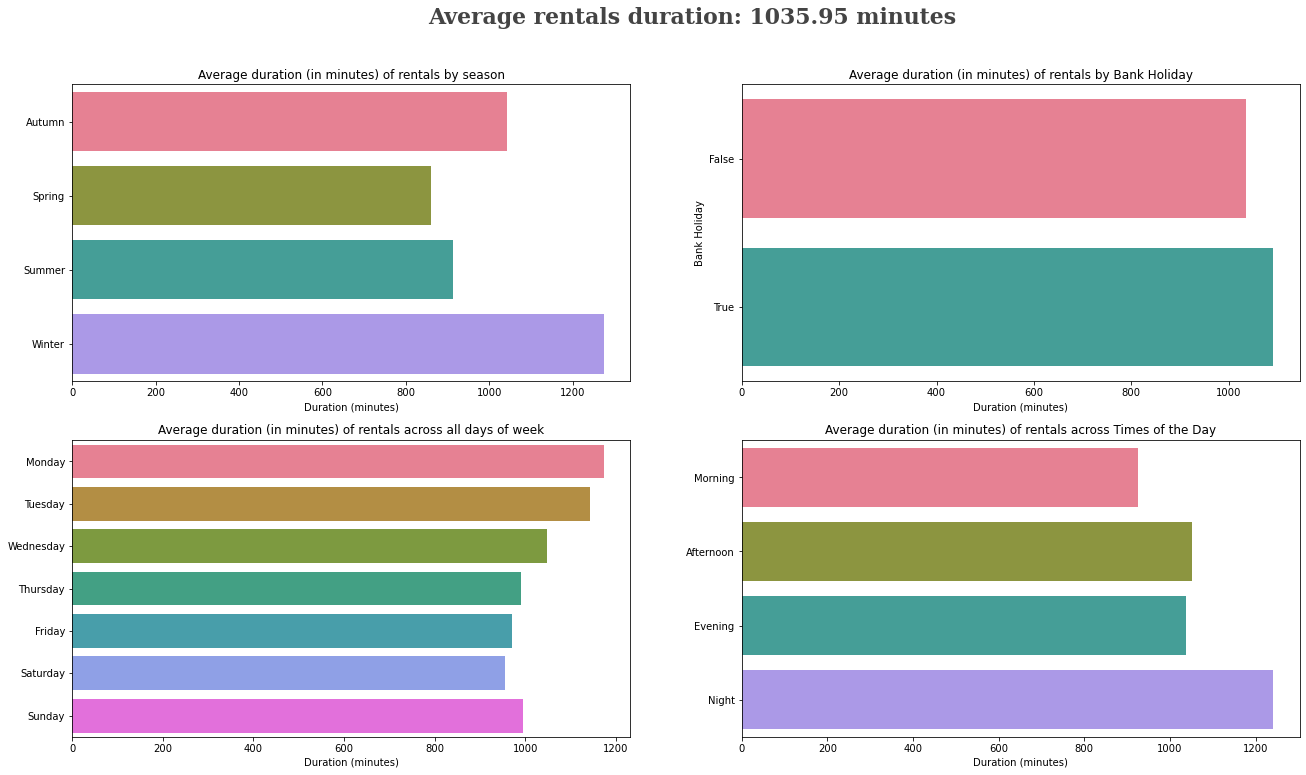

In [136]:
fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(22, 12))

# fig.text(0.125,1.1, avg_rental_duration, fontfamily='serif',fontsize=14, fontweight='bold', color='#444444')
fig.text(0.35,0.95,avg_rental_duration,fontfamily='serif',fontsize=22,fontweight='bold',color='#444444')

season_rentduration = all_data.groupby(['season'])['duration'].mean()
sns.barplot(x=season_rentduration.values, y=season_rentduration.index, ax=ax[0][0], orient='h', palette='husl')
ax[0][0].set(xlabel='Duration (minutes)', ylabel='', title='Average duration (in minutes) of rentals by season')

day_of_week_rentduration = all_data.groupby(['dayofweek'])['duration'].mean()
sns.barplot(x=day_of_week_rentduration.values, y=day_of_week_rentduration.index, ci=None, ax=ax[1][0],
            order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'], orient='h', palette='husl')
ax[1][0].set(xlabel='Duration (minutes)', ylabel='', title='Average duration (in minutes) of rentals across all days of week')

holiday_rentduration = all_data.groupby(['holiday'])['duration'].mean()
sns.barplot(x=holiday_rentduration.values, y=holiday_rentduration.index, ax=ax[0][1], orient='h', palette='husl')
ax[0][1].set(xlabel='Duration (minutes)', ylabel='Bank Holiday', title='Average duration (in minutes) of rentals by Bank Holiday')
# ax[0][1].bar_label(ax[0][1].containers[0])

timesofday_rentduration = all_data.groupby(['timesofday'])['duration'].mean()
sns.barplot(x=timesofday_rentduration.values, y=timesofday_rentduration.index, ax=ax[1][1],
            order=['Morning','Afternoon','Evening','Night'], orient='h', palette='husl')
ax[1][1].set(xlabel='Duration (minutes)', ylabel='', title='Average duration (in minutes) of rentals across Times of the Day')

plt.show()

We can spot a few patterns when in colder days (Autumn and Winter | Night), the duration of rentals on average is higher. It seems that, on average, customers stay longer with bikes on early days of the week (Monday, Tuesday and Wednesday). On the other hand, it does not seem to be a difference on average rentals duration on Bank Holidays.

## Battery distribution

In [137]:
battery_dist_df = all_data[all_data['duration'] > 0].copy()

def group_battery_status(df):

    bins= [0,30,50,80,100]
    labels = ['< 30%','30% - 50%','50% - 80%','> 80%']
    df['battery_status'] = pd.cut(df['start_battery'], bins=bins, labels=labels, right=False)

    s = df.battery_status
    counts = s.value_counts()
    percent = s.value_counts(normalize=True)
    df_summary = pd.DataFrame({'counts': counts, 'per': percent}, labels)
    df_summary['per100'] = round((df_summary['per']*100),2).astype(str) + '%'
    
    return df_summary

battery_dist = group_battery_status(battery_dist_df)
battery_dist

,counts,per,per100
< 30%,4482,0.086272,8.63%
30% - 50%,9552,0.183862,18.39%
50% - 80%,22236,0.428010,42.8%
> 80%,15682,0.301856,30.19%


### Initial battery density

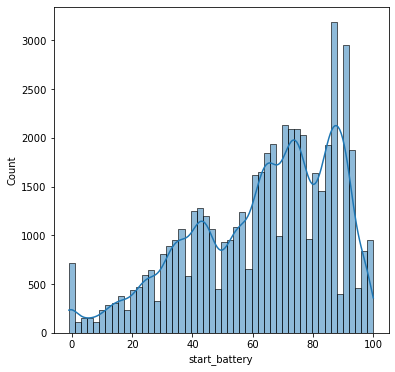

In [115]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.histplot(data=battery_dist_df, x='start_battery', kde=True)
plt.show()

<img title="GitHub Mark" src="./img/GitHub-Mark-64px.png" style="height: 32px; padding-right: 15px" alt="GitHub Mark" align="left"> [GitHub repository](https://github.com/pessini/moby-bikes) <br>Author: Leandro Pessini